In [289]:
reset -fs

In [290]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
%matplotlib inline
sns.set()

-----

# EDA for babynames

General Tasks: Find good name that starts with 'S', for both boy and girl

## Load Data

In [291]:
raw_national = pd.read_csv("../data/NationalNames.csv")
raw_national.shape

(1825737, 5)

In [292]:
raw_national.head()

,Id,Name,Year,Gender,Count
0,1,Mary,1880,F,7065
1,2,Anna,1880,F,2604
2,3,Emma,1880,F,2003
3,4,Elizabeth,1880,F,1939
4,5,Minnie,1880,F,1746


In [293]:
# more than 5M rows, let's choose a sample
# raw_nat_sample = raw_national.sample(n=100000)

raw_nat_sample = raw_national.copy()
raw_nat_sample.shape

(1825737, 5)

### Pythonize Column Names

In [294]:
# take a look
raw_nat_sample.columns = map(lambda x : x.lower().replace(' ','_').replace('count','frequency'),raw_nat_sample.columns)
raw_nat_sample.head(10)

,id,name,year,gender,frequency
0,1,Mary,1880,F,7065
1,2,Anna,1880,F,2604
2,3,Emma,1880,F,2003
3,4,Elizabeth,1880,F,1939
4,5,Minnie,1880,F,1746
5,6,Margaret,1880,F,1578
6,7,Ida,1880,F,1472
7,8,Alice,1880,F,1414
8,9,Bertha,1880,F,1320
9,10,Sarah,1880,F,1288


In [295]:
# we don't care about 'state', let's drop it
groups = raw_nat_sample.groupby(['name','year','gender'])
raw_nat_sample = groups.aggregate({'id':min,'frequency':sum}).reset_index().set_index('id')
raw_nat_sample.head()

,name,year,gender,frequency
id,,,,
1585933,Aaban,2007,M,5
1654167,Aaban,2009,M,6
1685637,Aaban,2010,M,9
1718295,Aaban,2011,M,11
1752147,Aaban,2012,M,11


### Task 1: find out classical names

Classical name is names with longest historical data. Because if a name appears in each every year, it means it's popular.

In [296]:
name_year_count = raw_nat_sample.copy()
name_year_count['history'] = name_year_count.groupby(['name','gender'])['year'].transform('count')
name_year_count.head(10)

,name,year,gender,frequency,history
id,,,,,
1585933,Aaban,2007,M,5,7
1654167,Aaban,2009,M,6,7
1685637,Aaban,2010,M,9,7
1718295,Aaban,2011,M,11,7
1752147,Aaban,2012,M,11,7
1784445,Aaban,2013,M,14,7
1817171,Aaban,2014,M,16,7
1705078,Aabha,2011,F,7,3
1742455,Aabha,2012,F,5,3


In [297]:
# find names with most long history data
def get_classical_name_billboard(since=1880):
    return name_year_count[name_year_count.year >= since].groupby(['name','gender']) \
    .aggregate({'frequency':sum,'history':min}) \
    .sort_values(by=['history','frequency'], ascending=False)

#t = get_classical_name_billboard()
#print(t.ix[(t.index.get_level_values('Rachel',level='name')) & (t.index.get_level_values('F',level='gender'))])
#print(t.loc['Rachel','F'])

print(get_classical_name_billboard().head())
def find_classical_rank(name,gender,since=1910):
    '''
    name, e.g.'John'
    gender, e.g. 'M' or 'F'
    
    return: rank in classical name billboard
    '''
    #print(names_with_long_history_sorted.head())
    billboard = get_classical_name_billboard(since).reset_index()
    return billboard[(billboard.name==name) & (billboard.gender==gender)].index[0]+1


find_classical_rank('Rachel','F',since=1910)

                frequency  history
name    gender                    
James   M         5106285      135
John    M         5085371      135
Robert  M         4796992      135
Michael M         4309607      135
Mary    F         4115456      135


79

('James', 'M')


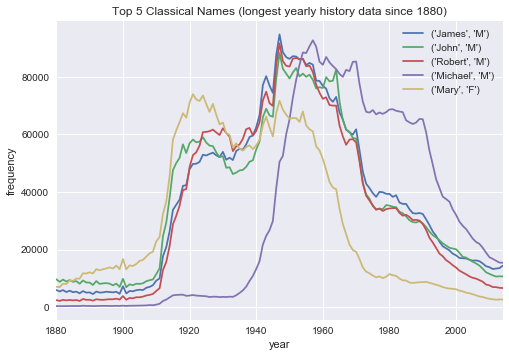

In [298]:
# print the most classical name (name with longest yearly history data)

N = 5
since=1880

classical_billboard = get_classical_name_billboard(since=since)
classical_billboard.head()
print(classical_billboard.index[0])
# print(classical_billboard[classical_billboard.index[0]])
year_frequency = name_year_count.groupby(['name','gender','year']).frequency.sum()
for i in range(N):
    # we need this evil for loop, otherwise dropna() is dropping the whole column
    year_frequency[classical_billboard.index[i]].plot(kind='line');
plt.legend(classical_billboard.index[:N])
plt.title(f"Top {N} Classical Names (longest yearly history data since {since})");
plt.xlabel("year");
plt.ylabel("frequency");

### Taks 2: find out frequent names

Frequent names is purely depends on frequency of past occurance, since a particular year, regardless of "how many years of historical data".

In [299]:
def get_frequent_name_billboard(since=1880):
    '''
    since: begining of year
    
    return: list of [name, gender, avg_year_frequency]
    '''
    return name_year_count[name_year_count.year >= since].groupby(['name','gender']) \
    .aggregate({'frequency':'mean'}) \
    .sort_values(by=['frequency'], ascending=False)
    #return year_name_crosstab.loc[since:].mean(axis=0,skipna=True).sort_values(ascending=False)

get_frequent_name_billboard().head()

,,frequency
name,gender,
James,M,37824.333333
John,M,37669.414815
Robert,M,35533.274074
Michael,M,31923.014815
Mary,F,30484.859259


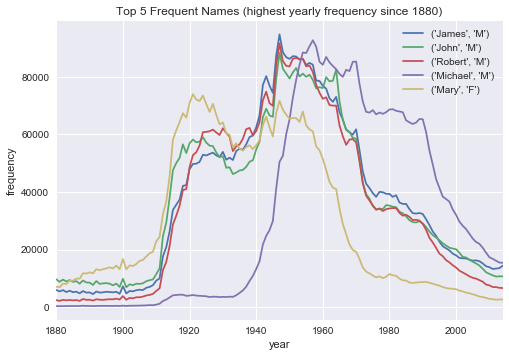

In [300]:
# print the most popular name (name with highest avg yearly frequency across history data)

N = 5
since=1880

frequent_name_billboard = get_frequent_name_billboard(since=since)
year_frequency = name_year_count.groupby(['name','gender','year']).frequency.sum()
for i in range(N):
    # we need this evil for loop, otherwise dropna() is dropping the whole column
    year_frequency[frequent_name_billboard.index[i]].dropna().plot(kind='line');
plt.legend(frequent_name_billboard.index[:N])
plt.title(f"Top {N} Frequent Names (highest yearly frequency since {since})");
plt.xlabel("year");
plt.ylabel("frequency");

### Task 3: print out frequency trend by given (name, gender)

Find out what is the yearly frequency trend by given (name, gender)

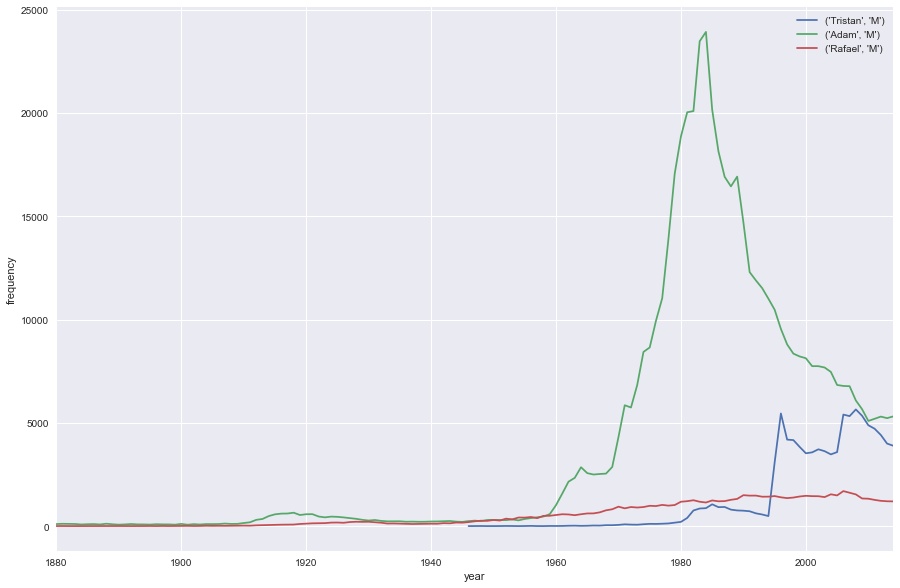

In [301]:
def print_name_frequency_trend(names,since=1880,figsize=(15,10)):
    """ Given a list of names, plot name yearly frequency trend"""
    plt.figure()
    plt.xlabel("year")
    plt.ylabel("frequency")
    year_frequency = name_year_count[name_year_count.year>=since].groupby(['name','gender','year']).frequency.sum()
    valid_names = list()
    for name in names:
        if name in year_frequency.index:
            year_frequency[name].plot(kind='line',figsize=figsize);
            valid_names.append(name)
    plt.legend(valid_names)

print_name_frequency_trend([('Tristan','M'),('Adam','M'),('Rafael','M')],since=1880)

### Task 4: find popular of names

Add column popularity by following definition:

$ popularity = \frac{frequency of (gender, name ,year)}{frequency of (gender,year)} $

Popularity is the percentage of frequency that a particular name takes among the same (year,gender) pair.

In [302]:
sample = raw_nat_sample.copy()

# prepare frequency_sum per (gender,year) group
pop_total = sample.groupby(['year','gender'])['frequency'].transform(sum)

# populate derived column: popularity
sample['popularity'] = sample['frequency']/pop_total

In [303]:
print(sample.shape)
print(raw_nat_sample.shape)
sample.head()

(1825737, 5)
(1825737, 4)


,name,year,gender,frequency,popularity
id,,,,,
1585933,Aaban,2007,M,5,0.000002
1654167,Aaban,2009,M,6,0.000003
1685637,Aaban,2010,M,9,0.000005
1718295,Aaban,2011,M,11,0.000006
1752147,Aaban,2012,M,11,0.000006


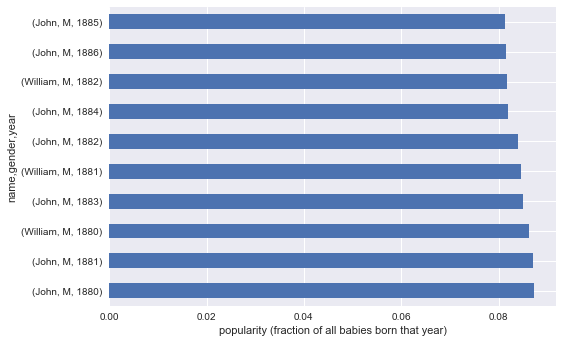

In [304]:
# show top N popular name of the year
plt.ylabel("(name,gender,year) pair")
plt.xlabel("popularity (fraction of all babies born that year)")
N = 10
sample.groupby(['name','gender','year']).popularity.sum().sort_values(ascending=False).head(N).plot(kind='barh');

### Task 5: which name has the largest sudden popularity gain v.s. 1 years before

In [305]:
# inspired by https://www.kaggle.com/dvasyukova/d/kaggle/us-baby-names/the-biggest-impacts-on-name-popularity

def popularity_diff(group,since=1880):
    '''
    group: group by object
    since: before this year, the 1st time you see a name is counted 0 pop diff
    '''
    # build year diff series
    yd = group.year.diff().fillna(0)
    # build popularity diff series
    popd = group.popularity.diff()
    # when there's a gap in year, treat the gap as 0, which means pop diff is the same as pop itself
    popd.loc[yd>1] = group.popularity.loc[yd>1]
    # reset first row per group to 0 before certain year
    popd.iloc[0] = group.popularity.iloc[0] if group.year.iloc[0] >= since else 0
    
    return popd

sample['popdiff']=sample.groupby(['name','gender']).apply(popularity_diff,since=2000).reset_index().set_index('id').popularity

KeyboardInterrupt: 

In [ ]:
def get_sudden_popular_name_billboard(since=1910):
    return sample[sample.year >=since].sort_values(by=['popdiff'],ascending=False)

In [ ]:
def find_sudden_popular_rank(name,gender,since=1910):
    score = get_sudden_popular_name_billboard(since=since).reset_index()
    return score[(score.name==name) & (score.gender == gender)].index[0]+1

In [ ]:
find_sudden_popular_rank('Sophia','F',since=since)

In [ ]:
get_sudden_popular_name_billboard()[:10]

In [ ]:
# top N sudden popular names by gender
N = 5
since = 2000
gender = 'M'

In [ ]:
scores = get_sudden_popular_name_billboard(since=since)[['name','gender']]
names = [(name, gender) for name in scores.name[scores.gender == gender].unique()[:N]]
print_name_frequency_trend(names,since=1984)

### Task 6: find good name that starts with 'S', for both boy and girl

#### Frequent Name

In [ ]:
N = 5
since = 1880
gender = 'F'

In [ ]:
freq_names = get_frequent_name_billboard(since=since).reset_index()
print_name_frequency_trend(freq_names[(freq_names.gender == gender) & (freq_names.name.str.contains('^S'))][:N][['name','gender']].apply(tuple,axis=1),since=since)

#### Popular Name

In [ ]:
N = 5
since = 2000
gender = 'M'

In [ ]:
table = get_sudden_popular_name_billboard(since=since)

names = table[(table.name.str.contains('^S')) & (table.gender==gender)].groupby(['gender','name']).first().sort_values(by='popdiff',ascending=False).reset_index()[['name','gender']].apply(tuple,axis=1)[:N]

print_name_frequency_trend(names,since=1880)

### Task 7:  Analyze impact of movies on name

In [ ]:
since = 1880

In [ ]:
data = get_sudden_popular_name_billboard(since=since)

In [ ]:
data = data[data.name == 'Tristan']
data.head()

In [ ]:
print_name_frequency_trend([('Tristan','M')])

[Lengend of the Fall (1994)](https://en.wikipedia.org/wiki/Legends_of_the_Fall)

### Task 8: Name Frequency Fit Distribution - Power Law

Power Law: $y = ax^b$

Log Power Law: $log(y) = log(a) + blog(x)$

Link Function: $log$

In [ ]:
# from scipy import optimize
import statsmodels.formula.api as smf

In [ ]:
topN = 1000

In [ ]:
freq = sample.groupby(['name'])['frequency'].mean().sort_values(ascending=False)[:topN]
freq = pd.DataFrame(freq).reset_index()
freq.frequency.plot();
plt.xlabel("name rank")
plt.ylabel("avg frequency");

In [ ]:
ydata = freq.frequency.values / freq.frequency.sum()
xdata = freq.index.values + 1 # avoid 0, which gives inf

In [ ]:
# Define function for calculating a power law
powerlaw = lambda x, amp, index: amp * (x**index)

In [ ]:
##########
# Fitting the data -- OLS
##########

# Power-law fitting is best done by first converting
# to a linear equation and then fitting to a straight line.
#
#  y = a * x^b
#  log(y) = log(a) + b*log(x)
#

logx = np.log(xdata)
logy = np.log(ydata)
x = np.vander(logx,N=2)
result = smf.OLS(logy,x).fit()
result.summary()

In [ ]:
index = result.params[0]
amp = np.exp(result.params[1])
print("index={},amp={}".format(index,amp))

In [ ]:
(freq.frequency / freq.frequency.sum()).plot();
x = np.linspace(1,topN,topN)
plt.plot(x, powerlaw(x,amp,index),'r-', lw=2, alpha=0.6, label='powerlaw pdf');
plt.xlabel("name rank")
plt.ylabel("probability")
plt.title("Power Law fit (PDF)");

### Task 8: Hypothesis Testing

Yesterday I attended a deeplearning4j workshop, and the guy sitting next to me from Salesforce is named Zachary.

$H_0$: I told the truth (because I always do)

$H_1$: I lied.

In [ ]:
# define statistics >> power law curve
# compute statistics >> rank of x
freq[freq.name=='Zachary']

In [ ]:
# compute p-value and compare with significant level α = 0.05
powerlaw(76,amp,index)

The p-value of meeting a guy named Zachary is less than significant level α = 0.05

Therefore, we reject the null hypothesis, which means I lied.

Fact: the guy sitting next to me from Salesforce was called Mehmet....

What's going wrong?
* It's not CLT (no normal curve). 
* It's point estimate from my power law distribution

-----
Let's do it again with CLT. Let's see whether gU5 class is a miracle!

$H_0$: it is normal to have a randomly assembled class with same name composition of gU5

$H_a$: it is not normal to have a randomly assembled class with same name compostion of gU5

In [ ]:
population = sample.groupby(['name'])['frequency'].mean().sort_values(ascending=False)
population = pd.DataFrame(population).reset_index()
μ = population.frequency.mean()
σ = population.frequency.std()
print("μ = {} σ = {}".format(μ,σ))

In [ ]:
gU5 = ['Adam',
       'Anton',
       'Ashleigh',
       'Chase',
       'Derek',
       'Eli',
       'Gavin',
       'Jaichitra',
       'Jed',
       'Jerry',
       'Minheng',
       'Paul',
       'Rafael',
       'Se',
       'Tai',
       'Tristan',
       'Vanessa',
       'Viviane'
      ]

In [ ]:
gU5_en = list(set(gU5).intersection(population.name.values))
gU5_en

In [ ]:
names_sample = population[population.name.isin(gU5_en)]
s = names_sample.std()[0]
x_ = names_sample.mean()[0]
t_score = (x_ - μ)/(s/np.sqrt(len(gU5_en)))
z_score = (x_ - μ)/σ
print("T Score:",t_score)
print("P Value for T Score is",stats.t(len(gU5_en) - 1).cdf(-t_score))
print("Z Score:",z_score)
print("P Value for Z Score is",stats.norm(0,1).cdf(-z_score))

Both p-value for T Score and Z Score is less than significant level α = 0.05

Reject null hypothesis, and __gU5 IS a miracle__!

### Task 9: predict length of names - Polynomial Regression

In [ ]:
sample['length']=sample.name.str.len()

In [ ]:
sample.head()

In [ ]:
namelen = sample.groupby(['year'])['length'].mean()
namelen = pd.DataFrame(namelen).reset_index()

In [ ]:
namelen.head()

In [ ]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns

In [ ]:
namelen.plot.scatter('year','length');

#### Linear

In [ ]:
sns.regplot(namelen.year,namelen.length,order=1);

#### Polynomial

In [ ]:
sns.regplot(namelen.year,namelen.length,order=2);

In [ ]:
x = np.vander(namelen.year,N = 3)
y = namelen.length.values
result = smf.OLS(y,x).fit()
result.summary()

In [ ]:
# predict
year_to_predict = 2020
result.predict([year_to_predict**2, year_to_predict, 1])

### Task 10: predict gender - Logistic Regression

In [ ]:
sample['gender_bin'] = sample.gender.apply({'M':0,'F':1}.get)
data = sample[:1000]
result = smf.logit(formula="gender_bin ~ length + year + frequency",data=data).fit();

In [ ]:
result.summary()

In [ ]:
# stripping off year and frequency, coz p-value is larger than significant level 0.05
result = smf.logit(formula="gender_bin ~ length",data=data).fit()
result.summary()

In [ ]:
namelength = 11
to_predict = pd.DataFrame(data=[namelength],columns=['length'])
print("Probability that this is Female Name is {:.3%}".format(result.predict(to_predict)[0]))
s = data[data.length == namelength].sample(1)
print("For example: {},{}".format(s.name.values[0],
                                 s.gender.values[0]))